In [1]:
import os
import numpy as np
import h5py
from PIL import Image
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
import seaborn as sns

# Scikit-learn imports
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models, transforms

First, the list of chosen bird species is defined:

In [2]:
species = [
    'Ciconia_ciconia', 'Columba_livia', 'Streptopelia_decaocto',
    'Emberiza_calandra', 'Carduelis_carduelis', 'Serinus_serinus',
    'Delichon_urbicum', 'Hirundo_rustica', 'Passer_domesticus',
    'Sturnus_unicolor', 'Turdus_merula'
]

And some settings are defined for pre-processing the images.

In [3]:
DATA_DIR = 'dataset'                        # Replace with your dataset path
MODEL_SAVE_DIR = 'saved_models'
OUTPUT_FILE = 'bird_dataset_pytorch.h5'     # Output HDF5 file

IMG_SIZE = (224, 224)                       # Standard size for CNNs
TEST_SIZE = 0.1                             # Test set proportion
COMPRESSION = 'gzip'                        # Compression type
COMPRESSION_LEVEL = 7                       # Compression level (1-9)

N_SPLITS = 5                                # Number of splits for cross-validation
BATCH_SIZE = 32                             # Batch size for DataLoader
NUM_EPOCHS = 30
NUM_CLASSES = 11
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The images of the various birds must be transformed so that they can be used in the models, using PyTorch's transforms.Compose(). The transformations include data augmentation for the training set and basic preprocessing for the test set. But what is data augmentation?

Data Augmentation is a technique used to expand a training dataset by creating modified versions of existing images through random but realistic transformations. It helps improve model generalization by exposing it to varied examples without collecting new data. Common transformations include flipping, rotating, scaling, changing brightness/contrast, adding noise, or cropping. These variations simulate different real-world scenarios, making the model more robust to changes in viewpoint, lighting, or orientation.

Data augmentation is applied only during training—validation and test data remain unmodified to reflect real-world performance. It is especially useful for small datasets, reducing overfitting and improving accuracy. 

Let's now break down each component and explain the hyperparameters:

- transforms.Resize(IMG_SIZE)- Resizes the image to a fixed size. This size is typically chosen based on model architecture, in this case 224x224.

- transforms.RandomHorizontalFlip()- Randomly flips the image horizontally with a default probability of 0.5.

- transforms.RandomRotation(20)- Rotates the image randomly by up to ±20 degrees.

- transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1)- Randomly adjusts brightness, contrast, and saturation by up to ±10%.

- transforms.ToTensor()- Converts the image to a PyTorch tensor (values scaled to [0, 1]).

- transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])- Normalizes the image using precomputed mean and std from ImageNet.




In [4]:
train_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
def createDataset():
    images = []
    labels = []
        
    for idx, specie in enumerate(species):
        specie_dir = os.path.join(DATA_DIR, specie)
            
        for img_name in os.listdir(specie_dir):
            img_path = os.path.join(specie_dir, img_name)
                
            try:
                img = Image.open(img_path)
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img = img.resize(IMG_SIZE)
                images.append(np.array(img))
                labels.append(idx)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    # Load and preprocess images
    print("Loading and preprocessing images...")
    X = np.array(images)
    y = np.array(labels)

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, stratify=y
    )

    #Cross Validation with Stratified K-Folds
    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

    #Saving in HDF5 format
    print(f"Saving data to {OUTPUT_FILE}...")
    os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
    with h5py.File(f"{MODEL_SAVE_DIR}/{OUTPUT_FILE}", 'w') as hf:
        #Test set
        test_group = hf.create_group('test')
        test_group.create_dataset('X_test', data=X_test, compression=COMPRESSION, compression_opts=COMPRESSION_LEVEL)
        test_group.create_dataset('y_test', data=y_test, compression=COMPRESSION, compression_opts=COMPRESSION_LEVEL)

        # Cross-validation splits
        cv_group = hf.create_group('cross_validation')
        for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
            fold_group = cv_group.create_group(f'fold_{fold + 1}')
            fold_group.create_dataset('X_train', data=X_train[train_idx], compression=COMPRESSION, compression_opts=COMPRESSION_LEVEL)
            fold_group.create_dataset('y_train', data=y_train[train_idx], compression=COMPRESSION, compression_opts=COMPRESSION_LEVEL)
            fold_group.create_dataset('X_val', data=X_train[val_idx], compression=COMPRESSION, compression_opts=COMPRESSION_LEVEL)
            fold_group.create_dataset('y_val', data=y_train[val_idx], compression=COMPRESSION, compression_opts=COMPRESSION_LEVEL)

        # Save metadata
        hf.attrs['species'] = np.array(species, dtype=h5py.string_dtype())
        hf.attrs['image_size'] = IMG_SIZE
        hf.attrs['n_splits'] = N_SPLITS
        hf.attrs['compression'] = COMPRESSION
        hf.attrs['compression_level'] = COMPRESSION_LEVEL
    print("Process completed successfully!")
    print(f"Data saved to {OUTPUT_FILE} with {COMPRESSION} compression level {COMPRESSION_LEVEL}")


In [6]:
def getDataloaders(filepath, idx, batch_size=BATCH_SIZE):
    with h5py.File(filepath, 'r') as hf:
        X_test = hf['test/X_test'][:]
        y_test = hf['test/y_test'][:]

        fold_group = hf[f'cross_validation/fold_{idx}']
        X_train = fold_group['X_train'][:]
        y_train = fold_group['y_train'][:]
        X_val = fold_group['X_val'][:]
        y_val = fold_group['y_val'][:]

        species = hf.attrs['species']
    
    # Apply transformations
    X_train = np.array([train_transforms(Image.fromarray(img)) for img in X_train])
    X_val = np.array([test_transforms(Image.fromarray(img)) for img in X_val])
    X_test = np.array([test_transforms(Image.fromarray(img)) for img in X_test])


    #Permute necessary for PyTorch (C, H, W) 
    X_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).long()
    X_val_tensor = torch.from_numpy(X_val).float()
    y_val_tensor = torch.from_numpy(y_val).long()
    X_test_tensor = torch.from_numpy(X_test).float()
    y_test_tensor = torch.from_numpy(y_test).long()

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader, species

In [7]:
def getModel(name, nClasses, dropout_rate=0):
    if name == 'resnet18':
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(model.fc.in_features, nClasses)
        )
    elif name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        model.classifier[1] = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(model.classifier[1].in_features, nClasses)
        )
    elif name == 'resnet34':
        model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(model.fc.in_features, nClasses)
        )
    return model.to(DEVICE)

def getOptimizer(model, params):
    if params['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    elif params['optimizer'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=0.9, weight_decay=params['weight_decay'])
    return optimizer

def trainModel(model, train_loader, val_loader, params):
    criterion = nn.CrossEntropyLoss()
    optimizer = getOptimizer(model, params)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3) if params['scheduler'] else None
    
    best_f1 = 0
    THRESHOLD = 5
    improvementCounter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': []}
    
    for epoch in range(NUM_EPOCHS):

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_running_corrects.double() / len(val_loader.dataset)
        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        
        if scheduler:
            scheduler.step(val_loss)
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            improvementCounter = 0
            torch.save(model.state_dict(), os.path.join(MODEL_SAVE_DIR, f'best_{params["model_name"]}_fold.pth'))
        else:
            improvementCounter +=1
            if improvementCounter >= THRESHOLD:
                break

    return history, best_f1

In [8]:
def gridSearch(filepath, n_splits, hyperparams):
    best_params = None
    best_f1 = 0
    
    # Generate all possible hyperparameter combinations
    keys, values = zip(*hyperparams.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    print(f"\nBeginning GridSearch with {len(param_combinations)} combinations...")
    
    for params in tqdm(param_combinations):
        print()
        print("="*50)
        print(f"Testing combination: {params}")
        fold_f1_scores = []
        
        # Cross-validation loop
        for fold_idx in range(1, n_splits+1):
            train_loader, val_loader, _, _ = getDataloaders(filepath, fold_idx, params['batch_size'])
            model = getModel(params['model_name'], NUM_CLASSES)
            model.to(DEVICE)
            _, fold_f1 = trainModel(model, train_loader, val_loader, params)
            print(f"{species[fold_idx]} Best F1 Score: {fold_f1:.4f}")
            fold_f1_scores.append(fold_f1)
            
            # Clear memory
            del model
            torch.cuda.empty_cache()
        
        # Calculate average F1 across folds
        avg_f1 = np.mean(fold_f1_scores)
        print(f"Average F1 across folds: {avg_f1:.4f}")
        
        # Update best parameters if improved
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_params = params
            print(f"New best parameters found with F1: {best_f1:.4f}")
    

    print("\nGridSearch completed!")
    torch.save(best_params, os.path.join(MODEL_SAVE_DIR, 'bestparams.pth'))


def bestTrainModel(filepath, best_params):
    train_loader, val_loader, test_loader, _ = getDataloaders(filepath, 1, best_params['batch_size'])
    trainset = torch.utils.data.ConcatDataset([train_loader.dataset, val_loader.dataset])
    trainloaderset = DataLoader(trainset, batch_size=best_params['batch_size'], shuffle=True)
    model = getModel(best_params['model_name'], NUM_CLASSES, best_params['dropout_rate'])
    model.to(DEVICE)
    bestHist,_ = trainModel(model, trainloaderset, test_loader, best_params)

    #Evaluate on test set
    model.eval()
    all_preds, all_labels = [], []
    test_loss = 0.0

    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            test_loss += loss.item() * inputs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss /= len(test_loader.dataset)
    test_acc = accuracy_score(all_labels, all_preds)
    test_f1 = f1_score(all_labels, all_preds, average='weighted')
    print("\nFinal Model Evaluation:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")

    return model, bestHist, (all_labels, all_preds), test_loss, test_acc, test_f1

In [ ]:
def plotting(history, cm, test_metrics, species):
    """Visualize training results and metrics"""
    plt.figure(figsize=(20, 12))
    
    # Ensure tensors are moved to CPU before converting to numpy
    true_labels = [label.cpu().numpy() if isinstance(label, torch.Tensor) else label for label in true_labels]
    pred_labels = [label.cpu().numpy() if isinstance(label, torch.Tensor) else label for label in pred_labels]
    
    # Plot training history
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(history['val_f1'], label='Validation F1')
    plt.title('Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    # Plot confusion matrix
    plt.subplot(2, 2, 4)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=species, yticklabels=species)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Print test metrics
    print("\nTest Set Metrics:")
    print(f"Loss: {test_metrics[0]:.4f}")
    print(f"Accuracy: {test_metrics[1]:.4f}")
    print(f"F1 Score: {test_metrics[2]:.4f}")

In [10]:
#createDataset()

In [11]:
# Main execution
# 1. Perform hyperparameter search

#params = {
#    'model_name': ['resnet18', 'efficientnet_b0', 'resnet34'],
#    'learning_rate': [0.001, 0.0005, 0.0001],
#    'batch_size': [BATCH_SIZE],
#    'weight_decay': [0, 0.001, 0.0001],
#    'optimizer': ['adam', 'sgd'],
#    'scheduler': [True, False],
#    'dropout_rate': [0, 0.2, 0.5]
#}

params = {
    'model_name': ['resnet34', 'efficientnet_b0'],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [BATCH_SIZE],
    'weight_decay': [0, 0.001],
    'optimizer': ['adam'],
    'scheduler': [True],
    'dropout_rate': [0, 0.5]
}

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
gridSearch(f"{MODEL_SAVE_DIR}/{OUTPUT_FILE}", N_SPLITS, params)  


Beginning GridSearch with 16 combinations...


  0%|          | 0/16 [00:00<?, ?it/s]


Testing combination: {'model_name': 'resnet34', 'learning_rate': 0.001, 'batch_size': 32, 'weight_decay': 0, 'optimizer': 'adam', 'scheduler': True, 'dropout_rate': 0}
Columba_livia Best F1 Score: 0.6399
Streptopelia_decaocto Best F1 Score: 0.6602
Emberiza_calandra Best F1 Score: 0.6536
Carduelis_carduelis Best F1 Score: 0.6396


  6%|▋         | 1/16 [1:03:52<15:58:11, 3832.75s/it]

Serinus_serinus Best F1 Score: 0.6359
Average F1 across folds: 0.6458
New best parameters found with F1: 0.6458

Testing combination: {'model_name': 'resnet34', 'learning_rate': 0.001, 'batch_size': 32, 'weight_decay': 0, 'optimizer': 'adam', 'scheduler': True, 'dropout_rate': 0.5}
Columba_livia Best F1 Score: 0.6332
Streptopelia_decaocto Best F1 Score: 0.6573
Emberiza_calandra Best F1 Score: 0.6158
Carduelis_carduelis Best F1 Score: 0.6692


 12%|█▎        | 2/16 [2:04:30<14:27:36, 3718.31s/it]

Serinus_serinus Best F1 Score: 0.6298
Average F1 across folds: 0.6411

Testing combination: {'model_name': 'resnet34', 'learning_rate': 0.001, 'batch_size': 32, 'weight_decay': 0.001, 'optimizer': 'adam', 'scheduler': True, 'dropout_rate': 0}
Columba_livia Best F1 Score: 0.6072
Streptopelia_decaocto Best F1 Score: 0.6110
Emberiza_calandra Best F1 Score: 0.5906
Carduelis_carduelis Best F1 Score: 0.5966


 19%|█▉        | 3/16 [3:03:13<13:06:16, 3628.97s/it]

Serinus_serinus Best F1 Score: 0.6593
Average F1 across folds: 0.6129

Testing combination: {'model_name': 'resnet34', 'learning_rate': 0.001, 'batch_size': 32, 'weight_decay': 0.001, 'optimizer': 'adam', 'scheduler': True, 'dropout_rate': 0.5}
Columba_livia Best F1 Score: 0.6146
Streptopelia_decaocto Best F1 Score: 0.6127
Emberiza_calandra Best F1 Score: 0.6024
Carduelis_carduelis Best F1 Score: 0.5881


 25%|██▌       | 4/16 [4:03:59<12:07:06, 3635.51s/it]

Serinus_serinus Best F1 Score: 0.5954
Average F1 across folds: 0.6026

Testing combination: {'model_name': 'resnet34', 'learning_rate': 0.0005, 'batch_size': 32, 'weight_decay': 0, 'optimizer': 'adam', 'scheduler': True, 'dropout_rate': 0}
Columba_livia Best F1 Score: 0.7259
Streptopelia_decaocto Best F1 Score: 0.7112
Emberiza_calandra Best F1 Score: 0.7133
Carduelis_carduelis Best F1 Score: 0.7203


 31%|███▏      | 5/16 [5:03:47<11:03:22, 3618.37s/it]

Serinus_serinus Best F1 Score: 0.7181
Average F1 across folds: 0.7178
New best parameters found with F1: 0.7178

Testing combination: {'model_name': 'resnet34', 'learning_rate': 0.0005, 'batch_size': 32, 'weight_decay': 0, 'optimizer': 'adam', 'scheduler': True, 'dropout_rate': 0.5}
Columba_livia Best F1 Score: 0.7300
Streptopelia_decaocto Best F1 Score: 0.7346
Emberiza_calandra Best F1 Score: 0.7193
Carduelis_carduelis Best F1 Score: 0.7069


 38%|███▊      | 6/16 [6:00:58<9:52:27, 3554.80s/it] 

Serinus_serinus Best F1 Score: 0.7129
Average F1 across folds: 0.7207
New best parameters found with F1: 0.7207

Testing combination: {'model_name': 'resnet34', 'learning_rate': 0.0005, 'batch_size': 32, 'weight_decay': 0.001, 'optimizer': 'adam', 'scheduler': True, 'dropout_rate': 0}
Columba_livia Best F1 Score: 0.7148
Streptopelia_decaocto Best F1 Score: 0.7164
Emberiza_calandra Best F1 Score: 0.7310
Carduelis_carduelis Best F1 Score: 0.7214


 44%|████▍     | 7/16 [7:00:32<8:54:09, 3561.10s/it]

Serinus_serinus Best F1 Score: 0.7204
Average F1 across folds: 0.7208
New best parameters found with F1: 0.7208

Testing combination: {'model_name': 'resnet34', 'learning_rate': 0.0005, 'batch_size': 32, 'weight_decay': 0.001, 'optimizer': 'adam', 'scheduler': True, 'dropout_rate': 0.5}
Columba_livia Best F1 Score: 0.7408
Streptopelia_decaocto Best F1 Score: 0.7190
Emberiza_calandra Best F1 Score: 0.6971
Carduelis_carduelis Best F1 Score: 0.7144


 50%|█████     | 8/16 [8:18:46<8:42:54, 3921.83s/it]

Serinus_serinus Best F1 Score: 0.7150
Average F1 across folds: 0.7173

Testing combination: {'model_name': 'efficientnet_b0', 'learning_rate': 0.001, 'batch_size': 32, 'weight_decay': 0, 'optimizer': 'adam', 'scheduler': True, 'dropout_rate': 0}
Columba_livia Best F1 Score: 0.7877
Streptopelia_decaocto Best F1 Score: 0.7927
Emberiza_calandra Best F1 Score: 0.7920
Carduelis_carduelis Best F1 Score: 0.7838


 56%|█████▋    | 9/16 [9:31:20<7:53:16, 4056.68s/it]

Serinus_serinus Best F1 Score: 0.7915
Average F1 across folds: 0.7895
New best parameters found with F1: 0.7895

Testing combination: {'model_name': 'efficientnet_b0', 'learning_rate': 0.001, 'batch_size': 32, 'weight_decay': 0, 'optimizer': 'adam', 'scheduler': True, 'dropout_rate': 0.5}
Columba_livia Best F1 Score: 0.7892
Streptopelia_decaocto Best F1 Score: 0.8043
Emberiza_calandra Best F1 Score: 0.7604
Carduelis_carduelis Best F1 Score: 0.7791


 62%|██████▎   | 10/16 [10:36:54<6:41:53, 4018.84s/it]

Serinus_serinus Best F1 Score: 0.7943
Average F1 across folds: 0.7854

Testing combination: {'model_name': 'efficientnet_b0', 'learning_rate': 0.001, 'batch_size': 32, 'weight_decay': 0.001, 'optimizer': 'adam', 'scheduler': True, 'dropout_rate': 0}
Columba_livia Best F1 Score: 0.7698
Streptopelia_decaocto Best F1 Score: 0.7862
Emberiza_calandra Best F1 Score: 0.7659
Carduelis_carduelis Best F1 Score: 0.7838


 69%|██████▉   | 11/16 [11:34:18<5:20:14, 3842.95s/it]

Serinus_serinus Best F1 Score: 0.7523
Average F1 across folds: 0.7716

Testing combination: {'model_name': 'efficientnet_b0', 'learning_rate': 0.001, 'batch_size': 32, 'weight_decay': 0.001, 'optimizer': 'adam', 'scheduler': True, 'dropout_rate': 0.5}
Columba_livia Best F1 Score: 0.7750
Streptopelia_decaocto Best F1 Score: 0.7876
Emberiza_calandra Best F1 Score: 0.7750
Carduelis_carduelis Best F1 Score: 0.7777


 75%|███████▌  | 12/16 [12:32:57<4:09:38, 3744.62s/it]

Serinus_serinus Best F1 Score: 0.7974
Average F1 across folds: 0.7825

Testing combination: {'model_name': 'efficientnet_b0', 'learning_rate': 0.0005, 'batch_size': 32, 'weight_decay': 0, 'optimizer': 'adam', 'scheduler': True, 'dropout_rate': 0}
Columba_livia Best F1 Score: 0.8067
Streptopelia_decaocto Best F1 Score: 0.8041
Emberiza_calandra Best F1 Score: 0.7983
Carduelis_carduelis Best F1 Score: 0.7780


 81%|████████▏ | 13/16 [13:34:42<3:06:37, 3732.49s/it]

Serinus_serinus Best F1 Score: 0.8407
Average F1 across folds: 0.8055
New best parameters found with F1: 0.8055

Testing combination: {'model_name': 'efficientnet_b0', 'learning_rate': 0.0005, 'batch_size': 32, 'weight_decay': 0, 'optimizer': 'adam', 'scheduler': True, 'dropout_rate': 0.5}
Columba_livia Best F1 Score: 0.8087
Streptopelia_decaocto Best F1 Score: 0.8060
Emberiza_calandra Best F1 Score: 0.7898
Carduelis_carduelis Best F1 Score: 0.8008


 88%|████████▊ | 14/16 [14:33:18<2:02:14, 3667.11s/it]

Serinus_serinus Best F1 Score: 0.8128
Average F1 across folds: 0.8036

Testing combination: {'model_name': 'efficientnet_b0', 'learning_rate': 0.0005, 'batch_size': 32, 'weight_decay': 0.001, 'optimizer': 'adam', 'scheduler': True, 'dropout_rate': 0}
Columba_livia Best F1 Score: 0.7987
Streptopelia_decaocto Best F1 Score: 0.8137
Emberiza_calandra Best F1 Score: 0.8143
Carduelis_carduelis Best F1 Score: 0.7932


 94%|█████████▍| 15/16 [15:42:47<1:03:38, 3818.42s/it]

Serinus_serinus Best F1 Score: 0.8275
Average F1 across folds: 0.8095
New best parameters found with F1: 0.8095

Testing combination: {'model_name': 'efficientnet_b0', 'learning_rate': 0.0005, 'batch_size': 32, 'weight_decay': 0.001, 'optimizer': 'adam', 'scheduler': True, 'dropout_rate': 0.5}
Columba_livia Best F1 Score: 0.8045
Streptopelia_decaocto Best F1 Score: 0.8191
Emberiza_calandra Best F1 Score: 0.7852
Carduelis_carduelis Best F1 Score: 0.7813


100%|██████████| 16/16 [16:51:05<00:00, 3791.57s/it]  

Serinus_serinus Best F1 Score: 0.8106
Average F1 across folds: 0.8002

GridSearch completed!



Final Model Evaluation:
Test Loss: 0.7172
Test Accuracy: 0.8116
Test F1 Score: 0.8104


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

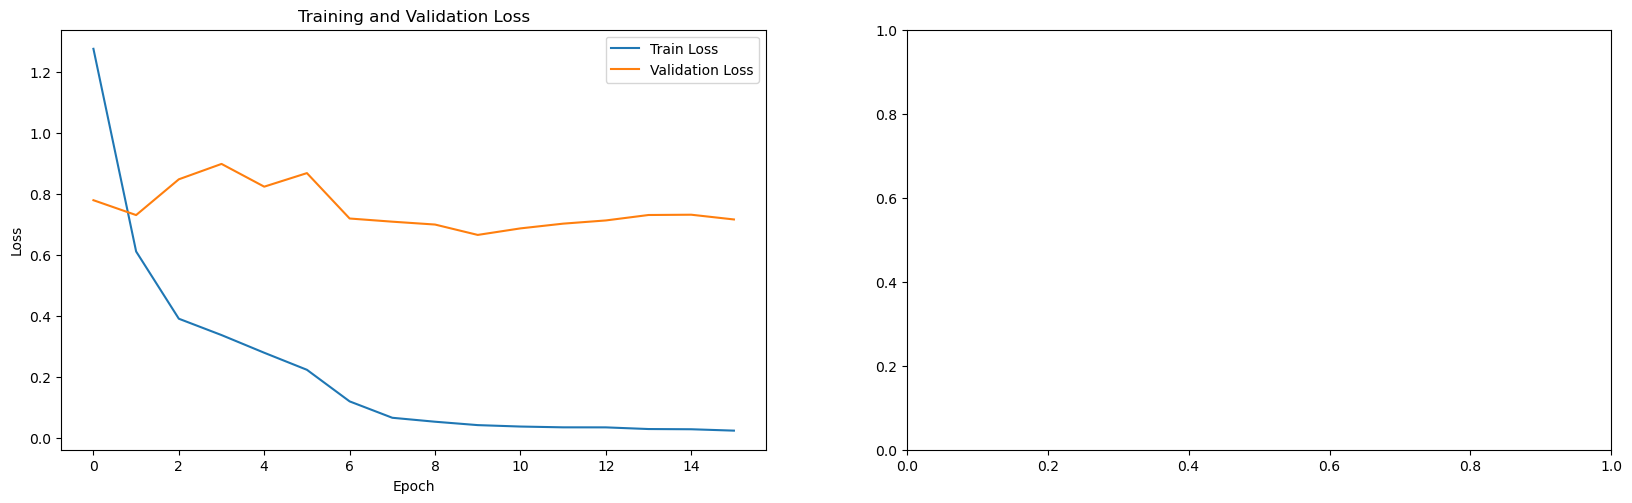

: 

In [ ]:
# 2. Train final model with best parameters
best_params = torch.load(os.path.join(MODEL_SAVE_DIR, 'bestparams.pth'))
final_model, history, (true_labels, pred_labels), test_loss, test_acc, test_f1 = bestTrainModel(f"{MODEL_SAVE_DIR}/{OUTPUT_FILE}", best_params)
    
# 3. Generate confusion matrix
cm = confusion_matrix([label.cpu().numpy() if isinstance(label, torch.Tensor) else label for label in true_labels], 
                      [label.cpu().numpy() if isinstance(label, torch.Tensor) else label for label in pred_labels])
    
# 4. Plot results
plotting(history, cm, (test_loss, test_acc, test_f1), final_model.species if hasattr(final_model, 'species') else species)
    
# 5. Save final model
torch.save({
    'model_state_dict': final_model.state_dict(),
    'best_params': best_params,
    'test_metrics': (test_loss, test_acc, test_f1)
}, os.path.join(MODEL_SAVE_DIR, 'final_model.pth'))
print("\nFinal model saved!")